<a href="https://colab.research.google.com/github/nickwotton/MQP2019/blob/master/Nick/BSM_NN_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attempt to Replicate the Black Scholes Model Using a Neural Network


In [0]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.stats as ss

## Define the Function
Here we define our function, the Black Scholes Model (BSM). First, we must initialize the option class, then the Geometric Brownian Motion Class, and finally the BSM class.
Then we test the equation with a test value of 2.

In [0]:
'''=========
option class init
=========='''
class VanillaOption:
    def __init__(
        self,
        otype = 1, # 1: 'call'
                  # -1: 'put'
        strike = 110.,
        maturity = 1.,
        market_price = 10.):
      self.otype = otype               # Put or Call
      self.strike = strike             # Strike K
      self.maturity = maturity         # Maturity T
      self.market_price = market_price #this will be used for calibration
      
        
    def payoff(self, s): #s: excercise price
      otype = self.otype
      k = self.strike
      maturity = self.maturity
      return np.max([0, (s - k)*otype])


In [0]:
'''============
Gbm class
============='''

class Gbm:
    def __init__(self,
                 init_state = 100.,
                 drift_ratio = .0475,
                 vol_ratio = .2
                ):
        self.init_state = init_state
        self.drift_ratio = drift_ratio
        self.vol_ratio = vol_ratio

In [0]:
'''========
Black-Scholes-Merton formula. 
=========='''

def bsm_price(self, vanilla_option):
    s0 = self.init_state
    sigma = self.vol_ratio
    r = self.drift_ratio
    
    otype = vanilla_option.otype
    k = vanilla_option.strike
    maturity = vanilla_option.maturity
    
    d1 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r + np.power(sigma,2)/2)*(maturity)) 
    d2 = 1/(sigma*np.sqrt(maturity))*(np.log(s0/k) + (r - np.power(sigma,2)/2)*(maturity)) 
    return (otype * s0 * ss.norm.cdf(otype * d1) #line break needs parenthesis
            - otype * np.exp(-r * maturity) * k * ss.norm.cdf(otype * d2))

Gbm.bsm_price = bsm_price

In [0]:
'''=======
Get BSM prices given an option and a vector
======='''

def vector_bsm(self, vanilla_option, data):
  outputData = []
  for i in data:
    gbm1.init_state = i
    callPrice = gbm1.bsm_price(vanilla_option)
    outputData.append(callPrice)
  return outputData

Gbm.vector_bsm = vector_bsm

## Create Model
Next, we create the neural network model. This is done first by setting the inner and outer dimensions with variables. Next we code the model and vary the internal dimensions to attempt to improve the model. At this level, this is essentially a simple linear algebra exercise:

If we have input $x$, internal parameters $a,b$, and solution $f(x)$ then in the one-dimensional case we have:

\begin{equation}
  \left(
    a_{1}x+b_{2}
  \right)
  a_{2} + b_{2}
  = f(x)
\end{equation}
  
However, we want to get a better estimate for the true equation. So we increase the interior dimension which corresponds to the number of neurons inside the network. For example, we raised the inner dimension to 3. In matrix form we have:

\begin{equation}
\left(
  \begin{bmatrix} x \end{bmatrix} 
  \begin{bmatrix} a_{1} & a_{2} & a_{3} \end{bmatrix} 
  + 
  \begin{bmatrix} b_{1} & b_{2} & b_{3} \end{bmatrix}
\right)
 \begin{bmatrix} a_{4} \\ a_{5} \\ a_{6} \end{bmatrix}
 +
 \begin{bmatrix} b_{4} \\ \end{bmatrix}
 =
 \begin{bmatrix} f(x) \end{bmatrix}
\end{equation}

Graphically, we can render this second neural network as:
![Neural Network Diagram](https://drive.google.com/uc?id=1ItiBpdjPvWHF5ZWy8JDNDKq6dXfyU-IE)

What we discovered here is that ReLU was slowing down the process, so since our function is Linear, we can just remove it. 

Additionally, we discerned that the higher the inner dimension, that is, the more nodes in each layer, the smaller the error and the better the performance.

In [0]:
#model
#nn.Linear
in_dim = 1
out_dim = 1
int_dim = 10

model = nn.Sequential(
    nn.Linear(in_dim, int_dim),
    nn.ReLU(),
    #nn.Linear(int_dim, int_dim),
    #nn.ReLU(),
    nn.Linear(int_dim, out_dim)
)

Here we define the Loss function as the Mean Squared Error(MSE). 

Note that by doing so, we are essentially 'cheating' the system. In most applications, we would not know the function $f$ so we would be unable to find the MSE.

In [0]:
#loss function 
criterion = nn.MSELoss()

Next we choose a learning rate and a method for learning. The learning rate is the percent of the data that is accepted in each iteration. The Methods we tried were SGD and Adam. 

In [0]:
#optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

## Train the Model

First we create the training data. This is a batch of random points that we pass through the BSM.

In [0]:
#training data

batch_size = 1000

x_trainPy = torch.randn(batch_size, 1)
#print(x_trainPy)
x_trainFlat = torch.flatten(x_trainPy)
#print(x_trainFlat)
x_train = np.abs(x_trainFlat.tolist())            # Convert to a list for ease of use, Take absolute value since we need stock prices > 0
#print(x_train)
x_trainScaled = [x * 100 for x in x_train]        # Scale list to make valid stock prices
#print(x_trainScaled)
gbm1 = Gbm()
option1 = VanillaOption()
y_train = gbm1.vector_bsm(option1, x_trainScaled)
#print(y_train)
#for i in x_trainScaled:
 # gbm1.init_state = i
  #callPrice = gbm1.bsm_price(option1)
  #y_train.append(callPrice)

#print(x_train)
#print(x_trainScaled)
#print(y_train)

x_trainTensor = torch.FloatTensor(x_trainScaled)  # Convert the data to a Tensor again for use in training the model
x_trainRotTensor = x_trainTensor.unsqueeze(1)     # Transpose the tensor to make it into the form we need for training

y_trainTensor = torch.FloatTensor(y_train)
y_trainRotTensor = y_trainTensor.unsqueeze(1)

#print(x_trainTensor)
#print(x_trainRotTensor)
#print(y_trainTensor)
#print(y_trainRotTensor)

Once we have the training data, we pass this collection of inputs and solutions into the model. With each iteration we calculate the loss and attempt to optimize the model to further reduce the loss.


In [111]:
# Train the model

num_epochs = 1000

for epoch in range(num_epochs):

    # Forward pass
    outputs = model(x_trainRotTensor)
    loss = criterion(outputs, y_trainRotTensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 
                                                    num_epochs, loss.item()))
        #print(x_trainRotTensor[0:10])
        #print(outputs[0:10])
        #print(y_trainRotTensor[0:10])


Epoch [50/1000], Loss: 1208.3547
Epoch [100/1000], Loss: 1207.5942
Epoch [150/1000], Loss: 1206.9716
Epoch [200/1000], Loss: 1206.4617
Epoch [250/1000], Loss: 1206.0442
Epoch [300/1000], Loss: 1205.7023
Epoch [350/1000], Loss: 1205.4222
Epoch [400/1000], Loss: 1205.1929
Epoch [450/1000], Loss: 1205.0050
Epoch [500/1000], Loss: 1204.8511
Epoch [550/1000], Loss: 1204.7250
Epoch [600/1000], Loss: 1204.6216
Epoch [650/1000], Loss: 1204.5369
Epoch [700/1000], Loss: 1204.4674
Epoch [750/1000], Loss: 1204.4105
Epoch [800/1000], Loss: 1204.3638
Epoch [850/1000], Loss: 1204.3254
Epoch [900/1000], Loss: 1204.2939
Epoch [950/1000], Loss: 1204.2679
Epoch [1000/1000], Loss: 1204.2467


## Testing the Model


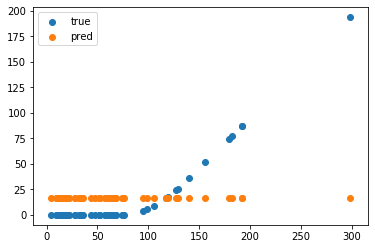

In [112]:
#test
x_Py = torch.randn(50,1)
x_Flat = torch.flatten(x_Py)
x_list = np.abs(x_Flat.tolist())            # Convert to a list for ease of use, Take absolute value since we need stock prices > 0
x_ = [x * 100 for x in x_list] 

y_ = gbm1.vector_bsm(option1, x_)

x_Tensor =  torch.FloatTensor(x_)           # convert back to tensor
x_RotTensor = x_Tensor.unsqueeze(1)

y_Tensor =  torch.FloatTensor(y_)           # convert back to tensor
y_RotTensor = y_Tensor.unsqueeze(1)
#print(y_RotTensor)
plt.scatter(x_RotTensor.detach().numpy(), y_RotTensor.detach().numpy(), label='true')

y_pred = model(x_RotTensor)
#print(y_pred)
plt.scatter(x_RotTensor.detach().numpy(), y_pred.detach().numpy(), label='pred')

plt.legend()